**Extracting parameters from the non-linear power spectrum using a Deep Neural Network**

Paper: arXiv:2106.11061

In [ ]:
#parameters [0=Omega_matter,1=Omega_baryon, 2=h, 3=ns, 4=sigma8] 

In [ ]:
# load the relevant Python libraries
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, Conv3D, MaxPooling3D,Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir project

In [ ]:
! cp /content/drive/MyDrive/sims64v2.zip project/

In [ ]:
! unzip project/sims64v2.zip
! rm project/sims64v2.zip

## **Power spectrum data (z=0)**

In [ ]:
#read the power spectra (X) and the relevant input parameters (y)
def load_PS_data():
    Xp = []
    yp = []
    print('Read PS')
    for i in range(2000):
        image_path = os.path.join('files/HR/Pk_m_z=0_'+ str(i) + '.txt')
        label_path = os.path.join('files/params_r_'+ str(i) + '.dat')
        img = np.loadtxt(image_path)
        lbl = np.loadtxt(label_path)
        Xp.append(img)
        yp.append(lbl)
    return Xp, yp

In [ ]:
Xp,yp = load_PS_data()
Xp = np.array(Xp)
yp = np.array(yp)

Read PS


In [ ]:
# remove the k-values as they are common to all spectra
# take the log of the spectra to decrease the spread of the input data 
Xp2 = np.delete(Xp,0,axis=2)
Xp2 = Xp2.reshape((-1, 886))
Xp3 = np.log(Xp2)

In [ ]:
# split the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(Xp3, yp, test_size=0.2, random_state=42)

In [ ]:
# scale the X and y data with a MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

min_max_scaler_y = MinMaxScaler()
y_train_minmax = min_max_scaler_y.fit_transform(y_train)
y_test_minmax = min_max_scaler_y.transform(y_test)




# Model with 5 parameters

In [ ]:
# Create and compile a DNN model to predict the 5 parameters
#Model PS
modelPS = tf.keras.models.Sequential()
modelPS.add(Dense(1024, activation='relu',input_shape=(886,)))
modelPS.add(Dropout(0.6))
modelPS.add(Dense(1024, activation='relu'))
modelPS.add(Dropout(0.6))
modelPS.add(Dense(1024, activation='relu'))
modelPS.add(Dropout(0.6))
modelPS.add(Dense(5, activation='linear'))

modelPS.summary()

modelPS.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              908288    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5

In [ ]:
# train model
historyPS = modelPS.fit(X_train_minmax,y_train_minmax, validation_split=0.1,epochs=300)

Epoch 1/300
45/45 [==============================] - 2s 36ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 2/300
45/45 [==============================] - 2s 37ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 3/300
45/45 [==============================] - 2s 36ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/300
45/45 [==============================] - 2s 36ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 5/300
45/45 [==============================] - 2s 36ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 6/300
45/45 [==============================] - 2s 35ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 7/300
45/45 [==============================] - 2s 35ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 8/300
45/45 [==============================] - 2s 35ms/step - loss: 0.

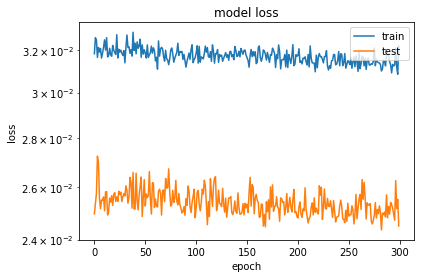

In [ ]:
# plot the learning curve
plt.semilogy(historyPS.history['loss'])
plt.semilogy(historyPS.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
predPS_train=modelPS.predict(X_train_minmax)

In [ ]:
predPS=modelPS.predict(X_test_minmax)

Text(0, 0.5, 'True value')

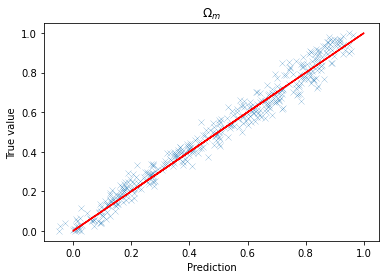

In [ ]:
# plot the predictions of Omega_m on the test set vs the ground truth (scaled values)
plt.scatter(predPS[:,0],y_test_minmax[:,0],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')

Text(0, 0.5, 'True value')

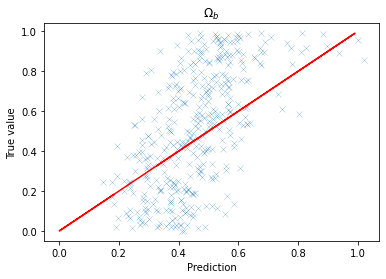

In [ ]:
# plot the predictions of Omega_b on the test set vs the ground truth (scaled values)
plt.scatter(predPS[:,1],y_test_minmax[:,1],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,1],y_test_minmax[:,1],'r')
plt.title('$\Omega_b$')
plt.xlabel('Prediction')
plt.ylabel('True value')

Text(0, 0.5, 'True value')

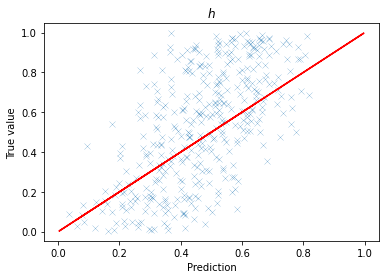

In [ ]:
# plot the predictions of h on the test set vs the ground truth (scaled values)
plt.scatter(predPS[:,2],y_test_minmax[:,2],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,2],y_test_minmax[:,2],'r')
plt.title('$h$')
plt.xlabel('Prediction')
plt.ylabel('True value')

Text(0, 0.5, 'True value')

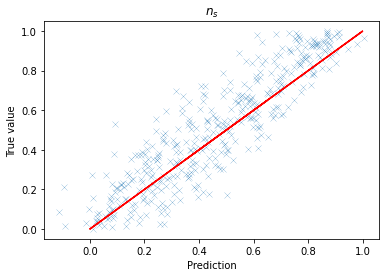

In [ ]:
# plot the predictions of n_s on the test set vs the ground truth (scaled values)
plt.scatter(predPS[:,3],y_test_minmax[:,3],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,3],y_test_minmax[:,3],'r')
plt.title('$n_s$')
plt.xlabel('Prediction')
plt.ylabel('True value')

Text(0, 0.5, 'True value')

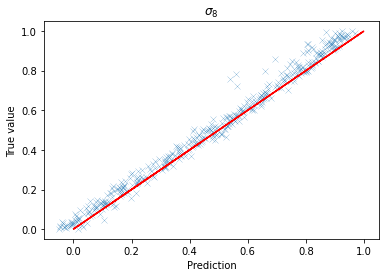

In [ ]:
# plot the predictions of sigma_8 on the test set vs the ground truth (scaled values)
plt.scatter(predPS[:,4],y_test_minmax[:,4],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,4],y_test_minmax[:,4],'r')
#plt.axis('equal')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')

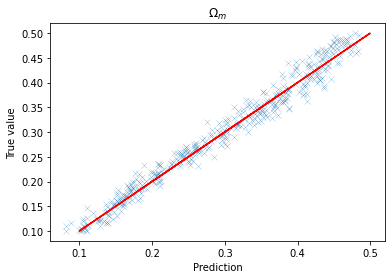

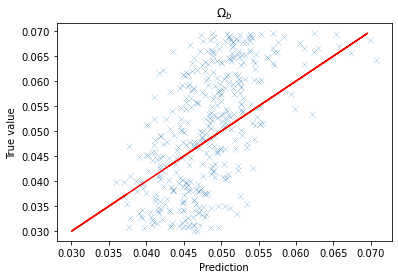

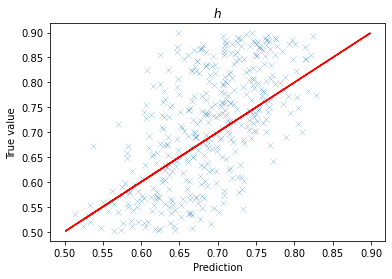

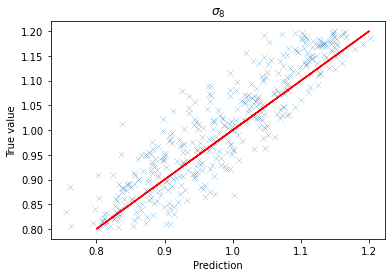

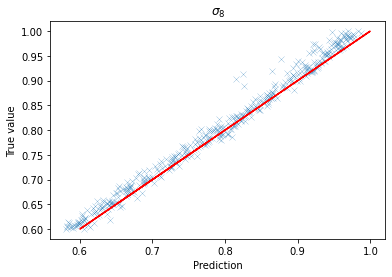

In [ ]:
# convert the scaled quantities back to their original ranges with inverse transformations & plot the results
v=np.zeros((400,1))
#toinvert5=np.column_stack((predPS[:,0],v,v,predPSc[:,1],predPSc[:,2]))
pred5p=min_max_scaler_y.inverse_transform(predPS)

plt.figure()
plt.scatter(pred5p[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(pred5p[:,1],y_test[:,1],marker='x',linewidth=0.2)
plt.plot(y_test[:,1],y_test[:,1],'r')
plt.title('$\Omega_b$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred5p[:,2],y_test[:,2],marker='x',linewidth=0.2)
plt.plot(y_test[:,2],y_test[:,2],'r')
plt.title('$h$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred5p[:,3],y_test[:,3],marker='x',linewidth=0.2)
plt.plot(y_test[:,3],y_test[:,3],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(pred5p[:,4],y_test[:,4],marker='x',linewidth=0.2)
plt.plot(y_test[:,4],y_test[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')


! mkdir /content/drive/MyDrive/results/ps5_dnn
np.savetxt('/content/drive/MyDrive/results/ps5_dnn/y_test.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/results/ps5_dnn/pred.csv', pred5p, delimiter=',')


# Model with 2 parameters (Omega_m, sigma_8)

In [ ]:
# bulid the model with 2 params

modelPSd = tf.keras.models.Sequential()
modelPSd.add(Dense(1024, activation='relu',input_shape=(886,)   ))
modelPSd.add(Dropout(0.6))
modelPSd.add(Dense(1024, activation='relu'  ))
modelPSd.add(Dropout(0.6))
modelPSd.add(Dense(1024, activation='relu'  ))
modelPSd.add(Dropout(0.6))
modelPSd.add(Dense(2, activation='sigmoid',))

modelPSd.summary()

modelPSd.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              908288    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

In [ ]:
# fit the model
historyPSd = modelPSd.fit(X_train_minmax,y_train_minmax[:,[0,4]], validation_split=0.1,epochs=400)

Epoch 1/400
45/45 [==============================] - 2s 35ms/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 2/400
45/45 [==============================] - 1s 32ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 3/400
45/45 [==============================] - 1s 32ms/step - loss: 0.1119 - mse: 0.1119 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 4/400
45/45 [==============================] - 1s 33ms/step - loss: 0.1096 - mse: 0.1096 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 5/400
45/45 [==============================] - 1s 32ms/step - loss: 0.1053 - mse: 0.1053 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 6/400
45/45 [==============================] - 1s 32ms/step - loss: 0.1034 - mse: 0.1034 - val_loss: 0.0712 - val_mse: 0.0712
Epoch 7/400
45/45 [==============================] - 1s 32ms/step - loss: 0.1019 - mse: 0.1019 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 8/400
45/45 [==============================] - 1s 32ms/step - loss: 0.

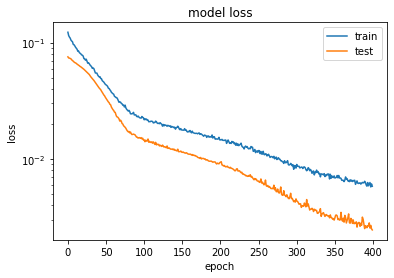

In [ ]:
# plot the learning curve
plt.semilogy(historyPSd.history['loss'])
plt.semilogy(historyPSd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

13/13 [==============================] - 0s 6ms/step - loss: 0.0027 - mse: 0.0027


Text(0, 0.5, 'True value')

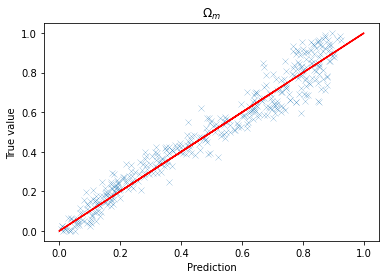

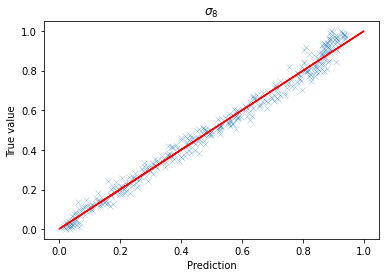

In [ ]:
# run model on the test set and plot the results

modelPSd.evaluate(X_test_minmax,y_test_minmax[:,[0,4]])

predPSd=modelPSd.predict(X_test_minmax)
#
plt.figure()
plt.scatter(predPSd[:,0],y_test_minmax[:,0],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#

plt.figure()
plt.scatter(predPSd[:,1],y_test_minmax[:,4],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,4],y_test_minmax[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')

In [ ]:
predPSd.shape

(400, 2)

Text(0, 0.5, 'True value')

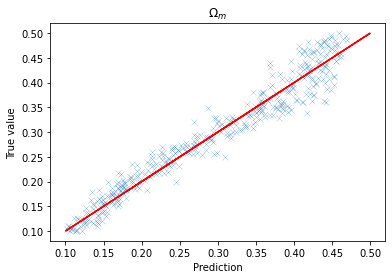

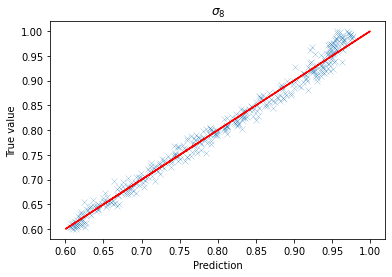

In [ ]:
v=np.zeros((400,1))
toinvert=np.column_stack((predPSd[:,0],v,v,v,predPSd[:,1]))
pred3=min_max_scaler_y.inverse_transform(toinvert)

plt.figure()
plt.scatter(pred3[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#

plt.figure()
plt.scatter(pred3[:,4],y_test[:,4],marker='x',linewidth=0.2)
plt.plot(y_test[:,4],y_test[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')

In [ ]:
! mkdir /content/drive/MyDrive/results/ps2_dnn

In [ ]:
! mkdir /content/drive/MyDrive/results/ps2_dnn
np.savetxt('/content/drive/MyDrive/results/ps2_dnn/y_test.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/results/ps2_dnn/pred.csv', pred3, delimiter=',')

# Model to predict 3 parameters



In [ ]:
# build DNN with 3 parameters
tf.keras.backend.clear_session()


from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.97
    decay_step = 50
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr
# 3 params
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]


modelPSc = tf.keras.models.Sequential()
modelPSc.add(Dense(1024, activation='relu',input_shape=(886,)   ))
modelPSc.add(Dropout(0.6))
modelPSc.add(Dense(1024, activation='relu'  ))
modelPSc.add(Dropout(0.6))
modelPSc.add(Dense(1024, activation='relu'  ))
modelPSc.add(Dropout(0.6))
modelPSc.add(Dense(3, activation='sigmoid',))

modelPSc.summary()

modelPSc.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              908288    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3

In [ ]:
#historyPSc = modelPSc.fit(X_train_minmax,y_train_minmax[:,[0,3,4]], validation_split=0.1, callbacks=callbacks, epochs=2000)
historyPSc = modelPSc.fit(X_train_minmax,y_train_minmax[:,[0,3,4]], validation_split=0.1,  epochs=900)

Epoch 1/900
45/45 [==============================] - 1s 33ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 2/900
45/45 [==============================] - 1s 33ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/900
45/45 [==============================] - 1s 32ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/900
45/45 [==============================] - 1s 33ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/900
45/45 [==============================] - 1s 33ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/900
45/45 [==============================] - 1s 32ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/900
45/45 [==============================] - 1s 31ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/900
45/45 [==============================] - 1s 31ms/step - loss: 0.

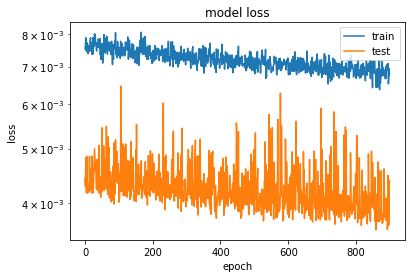

13/13 [==============================] - 0s 6ms/step - loss: 0.0051 - mse: 0.0051


Text(0, 0.5, 'True value')

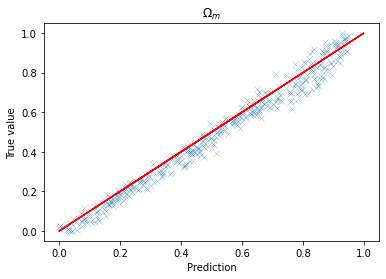

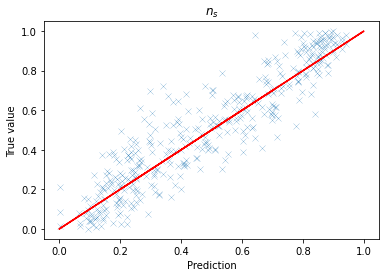

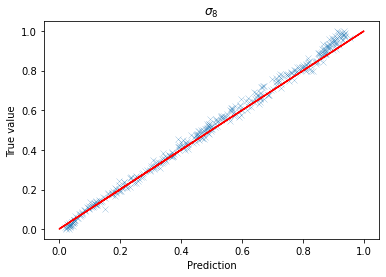

In [ ]:
# plot the learning curve and the scaled predictions vs ground truths
plt.semilogy(historyPSc.history['loss'])
plt.semilogy(historyPSc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


modelPSc.evaluate(X_test_minmax,y_test_minmax[:,[0,3,4]])

predPSc=modelPSc.predict(X_test_minmax)
#
plt.figure()
plt.scatter(predPSc[:,0],y_test_minmax[:,0],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(predPSc[:,1],y_test_minmax[:,3],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,0],y_test_minmax[:,0],'r')
plt.title('$n_s$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(predPSc[:,2],y_test_minmax[:,4],marker='x',linewidth=0.2)
plt.plot(y_test_minmax[:,4],y_test_minmax[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')


Omega_m
0.027024345575794976
n_s
0.15507069232261267
sigma_8
0.008253061182023512


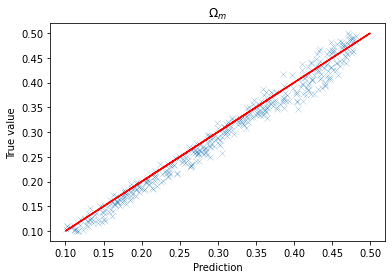

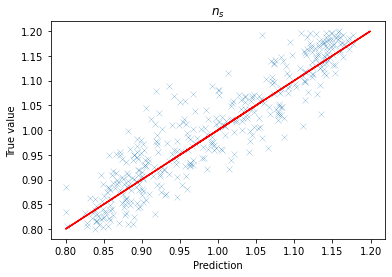

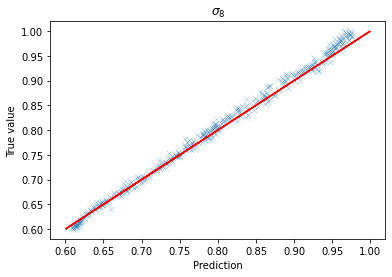

In [ ]:
# plot the predictions (on the test set) in the original ranges of the parameters
v=np.zeros((400,1))
toinvert3=np.column_stack((predPSc[:,0],v,v,predPSc[:,1],predPSc[:,2]))
pred3p=min_max_scaler_y.inverse_transform(toinvert3)

plt.figure()
plt.scatter(pred3p[:,0],y_test[:,0],marker='x',linewidth=0.2)
plt.plot(y_test[:,0],y_test[:,0],'r')
plt.title('$\Omega_m$')
plt.xlabel('Prediction')
plt.ylabel('True value')
#
plt.figure()
plt.scatter(pred3p[:,3],y_test[:,3],marker='x',linewidth=0.2)
plt.plot(y_test[:,3],y_test[:,3],'r')
plt.title('$n_s$')
plt.xlabel('Prediction')
plt.ylabel('True value')

plt.figure()
plt.scatter(pred3p[:,4],y_test[:,4],marker='x',linewidth=0.2)
plt.plot(y_test[:,4],y_test[:,4],'r')
plt.title('$\sigma_8$')
plt.xlabel('Prediction')
plt.ylabel('True value')

print('Omega_m')
ss0=sum((y_test[:,0]-np.mean(y_test[:,0]))**2)/400
t0=sum((y_test[:,0]-pred3p[:,0])**2)/400
print(t0/ss0)
#print('Omega_b')
#print(sum((y_test[:,1]-np.mean(y_test[:,1]))**2)/400)
#print(sum((y_test[:,1]-pred3[:,1])**2)/400)

#print('h')
#print(sum((y_test[:,2]-np.mean(y_test[:,2]))**2)/400)
#print(sum((y_test[:,2]-pred3[:,2])**2)/400)

print('n_s')
ss3=sum((y_test[:,3]-np.mean(y_test[:,3]))**2)/400
t3=sum((y_test[:,3]-pred3p[:,3])**2)/400
print(t3/ss3)

print('sigma_8')
ss4=sum((y_test[:,4]-np.mean(y_test[:,4]))**2)/400
t4=sum((y_test[:,4]-pred3p[:,4])**2)/400
print(t4/ss4)

In [ ]:
! mkdir /content/drive/MyDrive/results/ps3new_dnn
np.savetxt('/content/drive/MyDrive/results/ps3new_dnn/y_test.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/results/ps3new_dnn/pred.csv', pred3p, delimiter=',')